In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
df=pd.read_csv('ks-projects-201801.csv',encoding= 'latin_1')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [34]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

今回の方針  
nameは扱いが難しいので削除  
categoryは数が多すぎる、分類が細かすぎるので削除  
main_categoryは種類毎に数字化する  
currencyはcountryと相関が高そうだがとりあえず数字化する  
deadlineはとりあえず数字化するけど、本来は月とかだけでもいいかもしれない  
goalは使用しない、目標額にはusd_goal_realを使用する  
launchedは開始時刻、これは推定をするときにはわからないデータとして判断すると削除する方針  
pledgedは到達金額、つまり結果の事なので、今回の分類には使用しない  
stateは目的変数として使用する  
backersは支援者の数、これも結果なので、今回は使用しない  
countryは数字化するが、アメリカが多すぎるのでどう対応するかは迷う  
usd pledgedは結果なので使用しない。  
usd_goal_realは使用する。  


### 目的変数

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


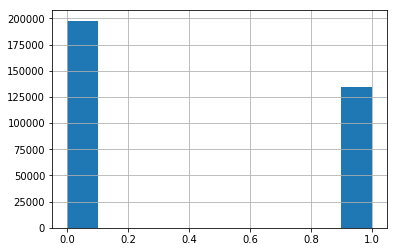

In [35]:
print(df['state'].value_counts())
dft=df.copy()
dft.drop(dft.index[dft.state == 'canceled'],inplace=True)
dft.drop(dft.index[dft.state == 'undefined'],inplace=True)
dft.drop(dft.index[dft.state == 'live'],inplace=True)
dft.drop(dft.index[dft.state == 'suspended'],inplace=True)
dft['state']=dft['state'].replace('failed',0)
dft['state']=dft['state'].replace('successful',1)
dft=dft.reset_index(drop=True)
dft['state'].hist(bins=10)

In [36]:
dft=dft.drop(['ID','name','category','usd pledged','goal','launched','pledged','backers','usd_pledged_real'],axis=1)
dft.head()

,main_category,currency,deadline,state,country,usd_goal_real
0,Publishing,GBP,2015-10-09,0,GB,1533.95
1,Film & Video,USD,2017-11-01,0,US,30000.00
2,Film & Video,USD,2013-02-26,0,US,45000.00
3,Music,USD,2012-04-16,0,US,5000.00
4,Food,USD,2016-04-01,1,US,50000.00


In [37]:
print(dft['main_category'].value_counts())

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64


In [38]:
dft['main_category']=dft['main_category'].replace('Film & Video',1)
dft['main_category']=dft['main_category'].replace('Music',2)
dft['main_category']=dft['main_category'].replace('Publishing',3)
dft['main_category']=dft['main_category'].replace('Games',4)
dft['main_category']=dft['main_category'].replace('Technology',5)
dft['main_category']=dft['main_category'].replace('Art',6)
dft['main_category']=dft['main_category'].replace('Design',7)
dft['main_category']=dft['main_category'].replace('Food',8)
dft['main_category']=dft['main_category'].replace('Fashion',9)
dft['main_category']=dft['main_category'].replace('Theater',10)
dft['main_category']=dft['main_category'].replace('Comics',11)
dft['main_category']=dft['main_category'].replace('Photography',12)
dft['main_category']=dft['main_category'].replace('Crafts',13)
dft['main_category']=dft['main_category'].replace('Journalism',14)
dft['main_category']=dft['main_category'].replace('Dance',15)
print(dft['main_category'].value_counts())

1     56527
2     45949
3     35445
4     28521
5     27050
6     25641
7     25364
8     22054
9     19775
10    10242
11     9878
12     9689
13     7818
14     4149
15     3573
Name: main_category, dtype: int64


In [39]:
print(dft['country'].value_counts())

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64


In [40]:
dft['country']=dft['country'].replace('US',1)
mask = dft.country != 1
dft.loc[mask,'country']=0
print(dft['country'].value_counts())

1    261360
0     70315
Name: country, dtype: int64


In [41]:
p = pd.to_datetime(dft.deadline).values
p = p.astype(np.float32)/(1000000000*60*60*24)
p = pd.DataFrame(p,dtype='float32')
dft = pd.concat([dft,p],axis=1)
dft = dft.rename(columns={0:'period'})

dft.head()

,main_category,currency,deadline,state,country,usd_goal_real,period
0,3,GBP,2015-10-09,0,0,1533.95,16717.0
1,1,USD,2017-11-01,0,1,30000.00,17471.0
2,1,USD,2013-02-26,0,1,45000.00,15762.0
3,2,USD,2012-04-16,0,1,5000.00,15446.0
4,8,USD,2016-04-01,1,1,50000.00,16892.0


In [42]:
dft=dft.drop(['deadline'],axis=1)
dft.head()

,main_category,currency,state,country,usd_goal_real,period
0,3,GBP,0,0,1533.95,16717.0
1,1,USD,0,1,30000.00,17471.0
2,1,USD,0,1,45000.00,15762.0
3,2,USD,0,1,5000.00,15446.0
4,8,USD,1,1,50000.00,16892.0


In [43]:
print(dft['currency'].value_counts())

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64


country は01にしてしまったので、currencyはきっちりと振り分けてみる  


In [44]:
dft['currency']=dft['currency'].replace('USD',1)
dft['currency']=dft['currency'].replace('GBP',2)
dft['currency']=dft['currency'].replace('EUR',3)
dft['currency']=dft['currency'].replace('CAD',4)
dft['currency']=dft['currency'].replace('AUD',5)
dft['currency']=dft['currency'].replace('SEK',6)
dft['currency']=dft['currency'].replace('MXN',7)
dft['currency']=dft['currency'].replace('NZD',8)
dft['currency']=dft['currency'].replace('DKK',9)
dft['currency']=dft['currency'].replace('CHF',10)
dft['currency']=dft['currency'].replace('NOK',11)
dft['currency']=dft['currency'].replace('HKD',12)
dft['currency']=dft['currency'].replace('SGD',13)
dft['currency']=dft['currency'].replace('JPY',14)
print(dft['currency'].value_counts())

1     261511
2      29476
3      14378
4      12375
5       6621
6       1510
7       1411
8       1274
9        929
10       652
11       584
12       477
13       454
14        23
Name: currency, dtype: int64


In [45]:
dft.head()

,main_category,currency,state,country,usd_goal_real,period
0,3,2,0,0,1533.95,16717.0
1,1,1,0,1,30000.00,17471.0
2,1,1,0,1,45000.00,15762.0
3,2,1,0,1,5000.00,15446.0
4,8,1,1,1,50000.00,16892.0


In [46]:
dft.corr()

,main_category,currency,state,country,usd_goal_real,period
main_category,1.000000,0.044497,-0.033510,-0.053063,-0.007471,0.147100
currency,0.044497,1.000000,-0.053551,-0.729780,0.003968,0.268716
state,-0.033510,-0.053551,1.000000,0.056250,-0.023735,-0.078055
country,-0.053063,-0.729780,0.056250,1.000000,-0.003756,-0.305595
usd_goal_real,-0.007471,0.003968,-0.023735,-0.003756,1.000000,0.012949
period,0.147100,0.268716,-0.078055,-0.305595,0.012949,1.000000


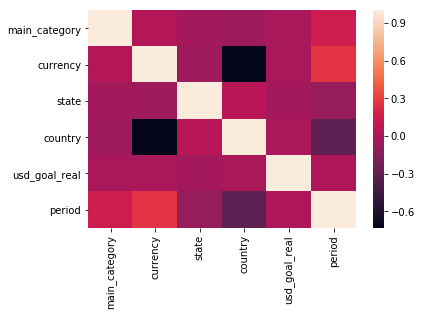

In [47]:
sns.heatmap(dft.corr())
plt.show()

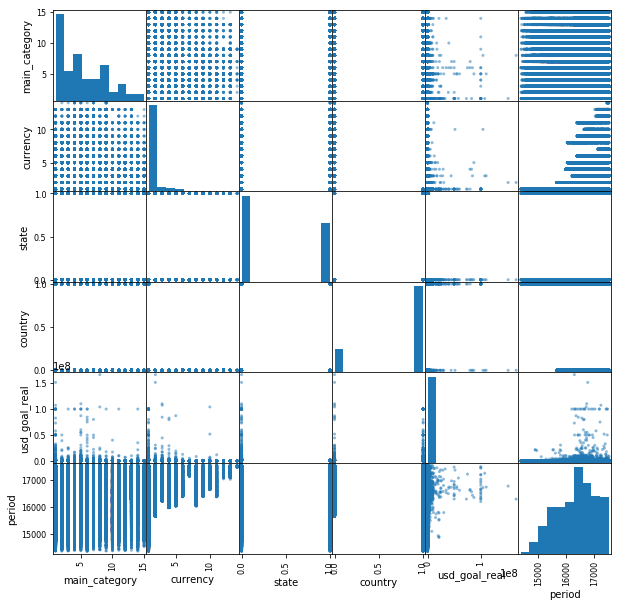

In [48]:
pd.plotting.scatter_matrix(dft, figsize=(10,10))
plt.show()

In [49]:
dft=dft.loc[:,['state','main_category', 'currency','country','usd_goal_real', 'period']]
dft.head()

,state,main_category,currency,country,usd_goal_real,period
0,0,3,2,0,1533.95,16717.0
1,0,1,1,1,30000.00,17471.0
2,0,1,1,1,45000.00,15762.0
3,0,2,1,1,5000.00,15446.0
4,1,8,1,1,50000.00,16892.0


stateに対する相関係数が驚くぐらい低いが、このままロジスティック回帰にかけてみる。

In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
y=dft.state.values
X=dft.iloc[:,1:].values
clf= SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)
y_est = clf.predict(X)
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

対数尤度 = -13.949
正答率 = 59.612%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,197719,0
正解 = 成功する,133956,0


案の定、ひどい結果になった  
数字データの値が大きかったり、ばらつき具合が不均一だったりしたので、そこだけ対応してみる。

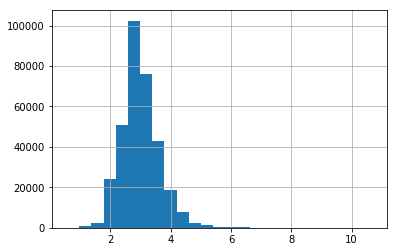

In [51]:
dft.usd_goal_real = np.sqrt(np.sqrt(np.sqrt(dft.usd_goal_real)))
dft['usd_goal_real'].hist(bins=25)

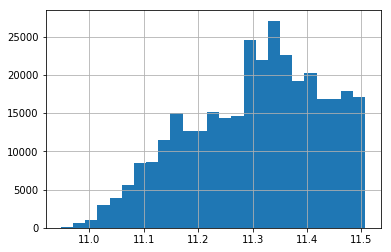

In [52]:
dft.period = np.sqrt(np.sqrt((dft.period)))
dft['period'].hist(bins=25)

In [53]:
y=dft.state.values
X=dft.iloc[:,1:].values
clf= SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)
y_est = clf.predict(X)
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

対数尤度 = -13.230
正答率 = 61.695%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,178127,19592
正解 = 成功する,107457,26499
